In [1]:
from datetime import timedelta

from feature_engine.selection import DropDuplicateFeatures, SmartCorrelatedSelection
from feature_engine.encoding import OneHotEncoder
import joblib
import mlflow
import mlflow.pytorch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
mlflow.set_experiment("rnn-timeseries")
pd.options.display.max_columns = None
np.set_printoptions(suppress=True)

In [3]:
data = pd.read_pickle("data/all_comp.pkl")

In [4]:
data["company"] = data["FileName"].copy()

In [5]:
train_dataframes_list = []
test_dataframes_list = []
for company in data.FileName.unique():
    temp_ds = data[data.FileName == company].sort_values("Date (AUS)").reset_index(drop=True)
    train_dataframes_list.append(temp_ds.iloc[:-60])
    test_dataframes_list.append(temp_ds.iloc[-60:])

In [6]:
data_copy = pd.concat(train_dataframes_list)
data_test = pd.concat(test_dataframes_list)

In [7]:
data_copy.FileName = data_copy.FileName.astype("category")
data_test.FileName = data_test.FileName.astype("category")

### Feature Analysis

In [8]:
drop_duplicate_features = DropDuplicateFeatures(variables=data_copy.columns.to_list())
data_copy = drop_duplicate_features.fit_transform(data_copy)
data_test = drop_duplicate_features.transform(data_test)

In [9]:
smart_correlated_selection = SmartCorrelatedSelection(variables=data_copy.drop(columns=["Open", "Close"]).select_dtypes(include=np.number).columns.to_list())
data_copy = smart_correlated_selection.fit_transform(data_copy)
data_test = smart_correlated_selection.transform(data_test)

In [ ]:
one_hot_encoder = OneHotEncoder(variables=["FileName"])
data_copy = one_hot_encoder.fit_transform(data_copy)
data_test = one_hot_encoder.transform(data_test)

In [ ]:
data_copy["target"] = data_copy["Open"].shift(-1).copy()
data_test["target"] = data_test["Open"].shift(-1).copy()

In [ ]:
joblib.dump(drop_duplicate_features, "artifacts/drop_duplicate_features.pkl")
joblib.dump(smart_correlated_selection, "artifacts/smart_correlated_selection.pkl")
joblib.dump(one_hot_encoder, "artifacts/one_hot_encoder.pkl")
#joblib.dump(min_max_scaler, "artifacts/min_max_scaler.pkl")
data_test.to_pickle("artifacts/data_test.pkl")

In [ ]:
one_hot_encoded_company_cols = [f"FileName_{col}" for col in one_hot_encoder.encoder_dict_["FileName"]]

In [ ]:
time_window=30
X_TS = []
X_CAT = []
Y = []
for company in one_hot_encoder.encoder_dict_["FileName"]:
    X_inner = []
    Y_inner = []
    X_company_inner = []
    dataset = data_copy[data_copy.company==company].copy().sort_values(by="Date (AUS)").drop(columns=["Date (AUS)", "Days Listed", "company", "ANN Freq.", "Posts", "Views", "Comments"]).reset_index(drop=True)
    for i in range(time_window, len(dataset)-time_window):
        this_window_data = dataset.drop(columns=["target"]+one_hot_encoded_company_cols).loc[i-time_window:i-1]
        this_array = this_window_data.values
        X_inner.append(this_array)
        Y_inner.append(dataset["target"].loc[i-1:i+28])
    X_array = np.array(X_inner)
    Y_array = np.array(Y_inner)
    X_TS.append(X_array)
    X_CAT.append(np.repeat(np.unique(dataset[one_hot_encoded_company_cols].values, axis=0), X_array.shape[0], axis=0))
    Y.append(Y_array)

In [ ]:
final_ts_array = np.vstack(X_TS)
final_cat_array = np.vstack(X_CAT)
final_y_array = np.concatenate(Y)

In [10]:
class TimeSeriesDataset(Dataset):
    """Time Series dataset."""

    def __init__(self, X_ts, X_cat, y):
        """
        """
        self.X_ts = torch.from_numpy(X_ts).float()
        self.X_cat = torch.from_numpy(X_cat).long()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X_ts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = {
            'X_ts': self.X_ts[idx], 
            'X_cat': self.X_cat[idx], 
            'y': self.y[idx]
        }

        return sample

In [ ]:
torch_dataset = TimeSeriesDataset(X_ts=final_ts_array, X_cat=final_cat_array, y=final_y_array)

In [ ]:
train_size = int(len(torch_dataset)*.75)
val_size = len(torch_dataset) - train_size

In [ ]:
train_dataset, val_dataset = random_split(torch_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))

In [ ]:
batch_size = 2048*3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [51]:
class TimeSeriesForecaster(pl.LightningModule):
    def __init__(
        self, 
        rnn_input_size,
        num_companies,
        dropout_ratio=0.4,
        rnn_hidden_size=512,
        rnn_stack_size=2,
        rnn_type="LSTM",
        learning_rate=0.001,
        linear_out_size=None,
    ):
        super().__init__()
        self.rnn_input_size = rnn_input_size
        self.dropout_ratio = dropout_ratio
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_stack_size = rnn_stack_size
        self.rnn_type = rnn_type
        if rnn_type == "GRU":
            rnn_layer = nn.GRU
        else:
            rnn_layer = nn.LSTM

        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size,
            hidden_size=self.rnn_hidden_size,
            num_layers=self.rnn_stack_size,
            batch_first=True,
            dropout=self.dropout_ratio if self.rnn_stack_size > 1 else 0,
        )
        self.lstm_drop = nn.Dropout(self.dropout_ratio)
        self.linear_out_size = linear_out_size

        # Linear layers
        self.linear1 = nn.Linear(in_features=self.rnn_hidden_size+num_companies, out_features=linear_out_size)
        self.linear_drop = nn.Dropout(self.dropout_ratio)
        self.linear_final = nn.Linear(
            in_features=linear_out_size, out_features=30
        )
        self.learning_rate = learning_rate
        
    def forward(self, X_ts, X_embed):
        """
        """
               
        
        # RNN
        # No need to worry about hidden states since when not
        # passed, they are automatically initialized as 0 arrays
        rnn_out, hidden = self.rnn(X_ts)
        
        if self.rnn_stack_size > 1:
            rnn_out = self.lstm_drop(rnn_out)

        # Stacking
        rnn_out = torch.cat((rnn_out[:,-1,:], X_embed), dim=-1)
        
        # Linear
        linear_out = self.linear1(rnn_out)
        linear_out = self.linear_drop(linear_out)
        linear_out = F.relu(linear_out)
        linear_out = self.linear_final(linear_out)
        return linear_out
    
    def on_train_start(self):
        """
        
        """
        
        self.logger.log_hyperparams(
            {
                "rnn_hidden_size": self.rnn_hidden_size,
                "rnn_stack_size": self.rnn_stack_size,
                "rnn_type": self.rnn_type,
            }
        )
        

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        X_ts = batch["X_ts"]
        X_embed = batch["X_cat"]
        y = batch["y"]
        
        final_out = self(X_ts, X_embed)
        loss = F.mse_loss(torch.squeeze(final_out), torch.squeeze(y))
        self.log("train_loss", loss, on_epoch=True)
        return loss
    
    def _shared_eval_step(self, batch):
        """
        Eval common steps
        """
        
        X_ts = batch["X_ts"]
        X_embed = batch["X_cat"]
        y = batch["y"]
        
        final_out = self(X_ts, X_embed)
        loss = F.mse_loss(torch.squeeze(final_out), torch.squeeze(y))
        
        return loss, final_out
    
    def validation_step(self, batch, batch_idx):
        # validation_step defines the validation loop.
        
        loss, final_out = self._shared_eval_step(batch)
        self.log("val_loss", loss, on_epoch=True)
        return {"val_loss": loss, "pred": final_out}
    
    def test_step(self, batch, batch_idx):
        # test_step defines the test loop.
        
        
        loss, final_out = self._shared_eval_step(batch)
        self.log("test_loss", loss, on_epoch=True)
        return {"test_loss": loss, "pred": final_out}
    
    def predict_step(self, batch, batch_idx):
        """
        Predict step
        """
        
        X_ts = batch["X_ts"]
        X_embed = batch["X_cat"]
        h_hat = self(X_ts, X_embed)
        return h_hat
        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [26]:
rnn_input_len = final_ts_array.shape[1]

NameError: name 'final_ts_array' is not defined

In [ ]:
hyperparams = {
    "rnn_input_size": final_ts_array.shape[2],
    "num_companies": final_cat_array.shape[1],
    # not a good idea to use rnn_stack_size of more than 1. It only degrades the model
    "rnn_stack_size": 1,
    "learning_rate": 0.0003,
    "rnn_hidden_size": 512,
    "linear_out_size": 128,
}

In [ ]:
model = TimeSeriesForecaster(**hyperparams)

In [ ]:
mlflow.pytorch.autolog(log_every_n_epoch=1, log_every_n_step=None, log_models=True, disable=False, exclusive=False, disable_for_unsupported_versions=False, silent=False, registered_model_name=None)

In [ ]:
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1000, log_every_n_steps=10, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10, check_on_train_epoch_end=True)])

In [ ]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    mlflow.log_param("time_window", time_window)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("train_size", train_size)
    mlflow.log_params(hyperparams)
    mlflow.log_artifacts("artifacts", artifact_path="pickles")
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
next(iter(train_loader))

### Inference

In [30]:
import json

import pandas as pd

In [31]:
run_id = "171feeb81e8a4e21af03d891a2bc8665"

In [32]:
data_test = pd.read_pickle(f"mlruns/1/{run_id}/artifacts/pickles/data_test.pkl")
#min_max_scaler = joblib.load(f"mlruns/1/{run_id}/artifacts/pickles/min_max_scaler.pkl")
one_hot_encoder = joblib.load(f"mlruns/1/{run_id}/artifacts/pickles/one_hot_encoder.pkl")
run_data = mlflow.get_run(run_id).data
time_window = int(run_data.params.get("time_window", 30))

In [33]:
one_hot_encoded_company_cols = [f"FileName_{col}" for col in one_hot_encoder.encoder_dict_["FileName"]]

In [34]:
logged_model = f'runs:/{run_id}/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pytorch.load_model(logged_model)

In [35]:
loaded_model

TimeSeriesForecaster(
  (rnn): LSTM(18, 512, batch_first=True)
  (lstm_drop): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=676, out_features=128, bias=True)
  (linear_drop): Dropout(p=0.4, inplace=False)
  (linear_final): Linear(in_features=128, out_features=30, bias=True)
)

In [52]:
hyperparams = {
    "rnn_input_size": 18,
    "num_companies": 676-512,
    # not a good idea to use rnn_stack_size of more than 1. It only degrades the model
    "rnn_stack_size": 1,
    "learning_rate": 0.0003,
    "rnn_hidden_size": 512,
    "linear_out_size": 128,
}
model = TimeSeriesForecaster(**hyperparams)
model.load_state_dict(loaded_model.state_dict())

<All keys matched successfully>

In [53]:
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=200, log_every_n_steps=30, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5, check_on_train_epoch_end=True)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
def create_input_data(data_test, company, time_window):
    """
    This is currently not generic and assumes that data is already preprocessed
    with standard scaler etc..
    """
    
    data_test_this_company = data_test[data_test.company==company].sort_values(by="Date (AUS)").drop(columns=["Date (AUS)", "Days Listed", "company", "ANN Freq.", "Posts", "Views", "Comments"]).reset_index(drop=True)
    X_ts = data_test_this_company.loc[:time_window-1].drop(columns=["target"]+one_hot_encoded_company_cols).values
    X_cat = np.unique(data_test_this_company.loc[:time_window-1][one_hot_encoded_company_cols].values, axis=0)
    y_true = data_test_this_company.loc[time_window:]["target"].values
    return X_ts, X_cat, y_true

In [55]:
def predict_current(X_ts, X_cat, model):
    """
    
    """
    
    test_dataset = TimeSeriesDataset(X_ts=X_ts, X_cat=X_cat, y=np.zeros((X_ts.shape[0])))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    y_pred = trainer.predict(model, test_loader)
    return y_pred

In [56]:
one_hot_encoder.encoder_dict_["FileName"][150:160]

['TIE', 'TMX', 'TNR', 'TRM', 'TRY', 'TTM', 'VAN', 'VKA', 'VMC', 'WAF']

In [57]:
company = "NCM"
X_ts, X_cat, y_true = create_input_data(data_test, company, time_window)
y_pred = predict_current(X_ts.reshape((1, X_ts.shape[0], X_ts.shape[1])), X_cat, model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/sam/anaconda3/envs/timeseries/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

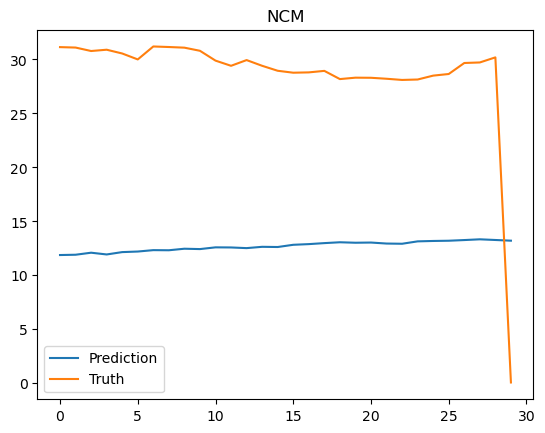

In [58]:
import matplotlib.pyplot as plt
plt.title(label=company)
plt.plot(torch.squeeze(y_pred[0]).numpy(), label = "Prediction")
plt.plot(y_true, label = "Truth")
plt.legend()
plt.show()

In [ ]:
F.mse_loss(torch.squeeze(y_pred[0]), torch.Tensor(y_true))